<a href="https://colab.research.google.com/github/marinaristol/QuantumMaster/blob/main/TFM_VQLS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VQLS algorithm in Qiskit



This code tries to solve a linear system of equations in the form $A\vec{x}=\vec{b}$
by searching a state $|x⟩$ that satisfies
$$A|x⟩∝|b⟩.$$

The inputs have to satisfy some conditions:


*   The state $|b⟩$ has to be prepared with efficient gates that we will name $U$.
*   The matrix $A$ has to be decomposed into a linear combination of $l$ unitaries as
$$A=∑_{n=1}^{l} c_n A_n $$
where $c_n$ are complex numbers and $A_n$ the unitaries.




In this notebook you can find all the code of the VQLS in   "*1. Functions (VQLS code)*", with its main function in "*Program function of the whole VQLS*". After this, the use case with the RLC circuit is applied  in  "*Implementation to RLC circuit*". The implementation of the VQLS code is in "*Solving it with RLC*". In the end, you can find the comparison between the VQLS, the classical and the analytical results in "*Final figure: comparing the results*".

To run this code, you have be careful first running the libraries and input cells and all the functions that are needed (basically, all the cells above).




## Libraries and inputs

Installing libraries:

In [1]:
%%capture
!pip install qiskit
!pip install pylatexenc
!pip install "qiskit[visualization]" #I don't know if something is missing here
!pip install pennylane --upgrade

#This is for not updating Qiskit Aer
!pip uninstall -y qiskit-aer
!pip install "qiskit-aer==0.12.0"

Becuase qiskit_aer is not compiling with the new update of qiskit, I am using the 12.0 version.

These are the inputs we will need for the program

In [2]:
import numpy as np
import pennylane as qml
from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit.library import StatePreparation
from qiskit_aer import AerSimulator #To extract the counts
from qiskit.extensions import UnitaryGate #To extract the gate of the b
import random
from scipy.optimize import minimize
from matplotlib import pyplot as plt # To plot

# 1. Functions (VQLS code)


## Functions to prepare the inputs


There are the functions that are needed to prepare the inputs that we give as
- The vector b in a ndarray form
- The matrix A or in a ndarray form or with its decomposition into its unitaries and coefficients

to the form of the inputs that are needed to run the VQLS.

In [3]:
def hermitian(matrix):
    '''
    Construct a hermitian matrix (with double dimension) if the input matrix
    isn't hermitian.

    Parameters
    ----------
    matrix : matrix input, to see if it's hermitian or not.

    Returns
    -------
    matrixc : Hermitian matrix

    '''

    if not np.allclose(matrix, matrix.conj().T):
        matrixa=np.asmatrix(matrix)
        matrixaH=np.asarray(matrixa.getH())
        sigmap=np.array([[0,1],[0,0]])
        sigmam=np.array([[0,0],[1,0]])

        matrixc=(np.kron(sigmap,matrix))+(np.kron(sigmam,matrixaH))

    if np.allclose(matrix, matrix.conj().T):
        matrixc=matrix

    return matrixc

In [4]:
def getgates(input_string):
    '''
    From the output of qml.pauli_decompose() it gets a list of the coefficients
    and the gates in terms of 0,1,2 to put it into the VQLS algorithm.

    Parameters
    ----------
    input_string : the gates and coefficients in a "hamiltonian" form that qml.pauli_decompose()
      give

    Returns
    -------
    coefficients : the coefficients correspending for each gates
    gate_set : the gates
    '''
    import re
    input_string=str(input_string)
    # Extract coefficients and gates using regular expressions
    coefficients = re.findall(r'(-?\d+\.\d+)', input_string)
    gates = re.findall(r'\[(.*?)\]', input_string)
    # Convert coefficients from strings to floats
    coefficients = [float(coeff) for coeff in coefficients]

    # Convert gates to numerical values
    gate_values=[]
    for elements in gates:
      elementlist=[]
      for element in elements[0:-1].split():
        if "I" in element:
          elementlist.append(0)
        elif "X" in element:
          elementlist.append(1)
        elif "Y" in element:
          elementlist.append(2)
        elif "Z" in element:
          elementlist.append(3)

      gate_values.append(elementlist)

    return coefficients, gate_values


In [5]:
def initialize_matr(matrix):
    '''
    A function to get the coefficients and the gate set from a matrix A.

    Parameters
    ----------
    matrix : the matrix A in ndarray

    Returns
    -------
    coefficient_set : list  of the coefficients
    gate_set : list of the gates for each qubit. It's in code. 0-I, 1-X,
        2-Y, 3-Z
    '''
    matrix=hermitian(matrix)

    #print('The matrix that we want to decompose:')
    #print(matrix)
    coefficient_set,gate_set=getgates(qml.pauli_decompose(matrix))

    return coefficient_set,gate_set

In [6]:
def getmatrixfromgates(coef,gate_set):
    '''
    From the coefficients and the gate set, get the matrix resultant (the A)
    '''

    matrix=np.zeros((2**(len(gate_set[0])),2**(len(gate_set[0]))),dtype=complex)
    for i in range(len(coef)):
        if (gate_set[i][0]==0):
            matrix0=np.eye(2)
        elif (gate_set[i][0]==1):
            matrix0=np.array([[0,1],[1,0]])
        elif (gate_set[i][0]==2):
             matrix0=np.array([[0,-1j],[1j,0]])
        elif (gate_set[i][0]==3):
             matrix0=np.array([[1,0],[0,-1]])
        for j in range(1,len(gate_set[i])):
            if (gate_set[i][j]==0):
                matrix0=np.kron(matrix0,np.eye(2))
            elif (gate_set[i][j]==1):
                matrix0=np.kron(matrix0,np.array([[0,1],[1,0]]))
            elif (gate_set[i][j]==2):
                matrix0=np.kron(matrix0,np.array([[0,-1j],[1j,0]]))
            elif (gate_set[i][j]==3):
                matrix0=np.kron(matrix0,np.array([[1,0],[0,-1]]))

           # print('matrix0',matrix0)
        matrix+=coef[i]*matrix0

    #matrixconj=matrix.conjugate()
    #if (matrixconj.dot(matrix) == matrix.dot(matrixconj)).all():
    #    print('A is normal')
    eigvalues=np.linalg.eigvals(matrix)
    #print('Eigenvalues',eigvalues)
    if np.iscomplex(eigvalues).any():
        print('Some eigenvalue is complex!!!')
    conditionnum=abs(eigvalues).max()/abs(eigvalues).min()

    if not np.iscomplex(matrix).any():
        matrix=np.real(matrix)

    return matrix,conditionnum

In [7]:
def getparameters(gates, layers):
  '''This function gets a set of random parameters in the shape that we want to. '''

  dim=len(gates[0])
  if dim==3:
    parameters=[float(random.randint(0,3000))/1000 for i in range(0, dim+2*dim*layers)]
  else:
    parameters=[float(random.randint(0,3000))/1000 for i in range(0, dim+layers*(2*dim-2))]
  return parameters

In [8]:
def init_matrix_vector(matrixa,vectorb, layers):
    ''' It prepares the two input of the VQLS: normalizing the b, the A, and making
    sure that A is hermitian and b is the vector that it corresponds.

    Parameters
    -----------
    matrixa: the initial ndarray
    vectorb: the initial vector b in ndarray
    layers : number of layers that we want for the ansatz

    Return
    -------
    coef: coeficients of the new matrixa. Input of the VQLS algorithm
    gates: gates of the new matrix A. Input of the VQLS algorithm
    norma: norm ()
    vectorb1: new vector b in ndarray
    '''

    #We redefine the matrix A to an hermitian one and the vector b equivalently
    if not np.allclose(matrixa, matrixa.conj().T):
        matrixa1=hermitian(matrixa)
        vectorb1=np.append(vectorb, np.zeros(len(vectorb)))

    if np.allclose(matrixa, matrixa.conj().T):
        matrixa1=matrixa
        vectorb1=vectorb

    #we normalize the vector and the matrix
    normb=np.linalg.norm(vectorb1)
    vectorb1=vectorb1/normb

    shape=matrixa1.shape[0]

    norma=np.linalg.norm(matrixa1,2) #We use the spectral norm to "normalize" the matrix
    if norma>1:
      matrixa1=(1/norma)*matrixa1

    #We are expanding the matrix for it to have 2**n dimensions and use N bits
    if np.log2(shape)%1!=0:
      newn = 2**(int(np.log2(shape)+1))
      newrows = newn - shape

      matrixa1 = np.append(matrixa1, np.zeros((newrows, shape)), axis=0 )
      matrixa1 = np.append(matrixa1, np.zeros((newn, newrows)), axis=1)

      vectorb1=np.append(vectorb1, np.zeros((newrows)))


    #We get the coeficients and the gates that give the new matrix a
    coef,gates=initialize_matr(matrixa1)

    #We see if the matrix and the vector use the same number of qubits
    if len(gates[0])!=np.ceil(np.log2(len(vectorb1))):
      raise TypeError("The matrix A and the vector b don't use the same number of qubits")

    #We set the parameters
    parameters=getparameters(gates,layers)

    return coef, gates, matrixa1, norma, shape, parameters, vectorb1, normb

In [9]:
def init_matrix_vector_extra(matrixa,vectorb, layers):
    ''' It prepares the two input of the VQLS: normalizing the b, the A, and making
    sure that A is hermitian and has an extra row and column with the last item
    being 1 and b is the vector also with the last item to 1.

    Parameters
    -----------
    matrixa: the initial ndarray
    vectorb: the initial vector b in ndarray
          it needs to be like "vector = np.array([1,1,1])" not with another []!
    layers : number of layers that we want for the ansatz

    Return
    -------
    coef: coeficients of the new matrixa. Input of the VQLS algorithm
    gates: gates of the new matrix A. Input of the VQLS algorithm
    norma: norm ()
    shape: the shape[0] of the matrix A before adding 0 to complete the 2**n dimensions
    vectorb1: new vector b in ndarray
    '''

    #We redefine the matrix A to an hermitian one and the vector b equivalently
    if not np.allclose(matrixa, matrixa.conj().T):
        matrixa1 = hermitian(matrixa)
        vectorb1 = np.append(vectorb, np.zeros(len(vectorb)))

    if np.allclose(matrixa, matrixa.conj().T):
        matrixa1 = matrixa
        vectorb1 = vectorb

    norma=np.linalg.norm(matrixa1,2) #We use the spectral norm to "normalize" the matrix
    if norma>1:
      matrixa1=(1/norma)*matrixa1

    #We add a dimension with the last item of the matrix and the vector = 1
    shape = matrixa1.shape[0] #As is squared
    matrixa1 = np.append(matrixa1,np.zeros((1,shape)),axis=0)
    append2 = np.append(np.zeros((shape,1)),1)
    append2 = append2.reshape(-1,1)
    matrixa1 = np.append(matrixa1, append2, axis=1)
    vectorb1 = np.append(vectorb1, 1)

    #we normalize the vector and the matrix
    normb=np.linalg.norm(vectorb1)
    vectorb1=vectorb1/normb

    #I should generalize this!
    #Now we have to get the matrix bigger if it's not 2**n
    shape = matrixa1.shape[0]

    if np.log2(shape)%1!=0:
      newn = 2**(int(np.log2(shape)+1))
      newrows = newn - shape

      matrixa1 = np.append(matrixa1, np.zeros((newrows, shape)), axis=0 )
      matrixa1 = np.append(matrixa1, np.zeros((newn, newrows)), axis=1)

      vectorb1=np.append(vectorb1, np.zeros((newrows)))


    #We get the coeficients and the gates that give the new matrix a
    print('DETERMINANT MATRIX',np.linalg.det(matrixa1))
    coef,gates=initialize_matr(matrixa1)

    #We see if the matrix and the vector use the same number of qubits
    if len(gates[0])!=np.ceil(np.log2(len(vectorb1))):
      raise TypeError("The matrix A and the vector b don't use the same number of qubits")

    #We set the parameters
    parameters=getparameters(gates,layers)

    return coef, gates, matrixa1, norma, shape, parameters, vectorb1, normb


##Building circuits

These are the functions that build some circuits (the ansatz, Hadamard Test, Hadamard Overlap Test...) and we will use in the *post process functions* which will get us the values that we need in order to evaluate the Cost Function.

Primary functions where are defined the ansatz part and the preparation of the state $|b⟩$, the U matrix.

In [12]:
def apply_fixed_ansatz(qubits, layers, parameters, circ):
  '''
    This is the circuit that prepares the ansatz V(k) into the qubits with the
    parameters (k) that are given and with  the number of layers of the input.

    Parameters
    ----------
    qubits : LIST WITH THE INDECES OF THE QUBITS.
        EXAMPLE: FOR 3 QUBITS WOULD BE [0,1,2].
    layers : NUMBER OF LAYERS. EACH LAYER IS COMPOSED BY INTERCALATED CZ, RY,CZ,RY.
    parameters : LIST OF LISTS WITH THE PARAMETERS
        EXAMPLE:  [ [1, 1, 1], [1, 1, 1], [1, 1, 1] ]
    circ: NAME OF THE QUANTUMCIRCUIT

    Returns
    -------
    THE QUANTUM CIRCUIT CIRC WITH THE NEW GATES

  '''
  if len(qubits)>3:
    if len(qubits)%2==0:
      if not ((len(parameters)==(1+layers*2)) and (all(len(x)==len(qubits) for x in parameters[1::2])) and (all(len(x)==(len(qubits)-2) for x in parameters[2::2]))):
        raise TypeError('The parameters variable do not have the desired shape.')
    if len(qubits)%2==1:
      print(len(parameters[1:]))
      if not ((len(parameters)==(1+layers*2)) and (all(len(x)==(len(qubits)-1) for x in parameters[1:]))):
        raise TypeError('The parameters variable do not have the desired shape.')


    for iz in range (0, len(qubits)):
      circ.ry(parameters[0][iz], qubits[iz])

    for nlay in range(layers):
      count=0
      for iz in range(0, len(qubits)):
        if (iz%2==1):
          circ.cz(qubits[iz-1],qubits[iz])
          circ.ry(parameters[nlay+(nlay+1)][count], qubits[iz-1]) #This is to reference for all the parameters in parameters list correctly
          circ.ry(parameters[nlay+(nlay+1)][count+1], qubits[iz])
          count+=2
      count=0
      for iz in range (0, len(qubits)):
        if (iz%2==1)and(iz!=len(qubits)-1):
          circ.cz(qubits[iz],qubits[iz+1])
          circ.ry(parameters[nlay+(nlay+2)][count], qubits[iz])
          circ.ry(parameters[nlay+(nlay+2)][count+1], qubits[iz+1])
          count+=2

  elif len(qubits)==3:

    for iz in range (0, len(qubits)):
          circ.ry(parameters[0][iz], qubits[iz])
    for nlay in range(layers):
      circ.cz(qubits[0], qubits[1])
      circ.cz(qubits[2], qubits[0])

      for iz in range (0, len(qubits)):
          circ.ry(parameters[1][iz], qubits[iz])
      circ.cz(qubits[1], qubits[2])
      circ.cz(qubits[2], qubits[0])

      for iz in range (0, len(qubits)):
          circ.ry(parameters[2][iz], qubits[iz])






In [13]:
def apply_circuitb(qubits,vec,circ):
    '''
    Function that applies the circuit that prepares the state b from the |0>.

    Parameters
    ----------
    qubits : THE LIST WITH THE INDECES OF THE QUBITS WHERE THE STATE IS
        IMPLEMENTED
    vec : THE VECTOR IN NP.ARRAY FORM OF THE B STATE
    circ : THE NAME OF THE QUANTUMCIRCUIT WHERE WE WANT TO IMPLEMENT B

    Returns
    -------
    THE QUANTUM CIRCUIT CIRC WITH THE APPLIED GATES

    '''
    num_qubits=np.ceil(np.log2(len(vec)))
    if np.linalg.norm(vec)!=1:
      initial_state = (vec)/np.linalg.norm(vec)
      #print('The state vector implemented it is the normalized one:',initial_state)

    if (len(qubits)==num_qubits):
        initial_state = (vec)/np.linalg.norm(vec)
        circ.initialize(initial_state, qubits)

    elif (len(qubits)> num_qubits):
        print('see if it is appyling correctly the ansatz')
        initial_state = vec/np.linalg.norm(vec)
        circ.initialize(initial_state, qubits)

    elif (len(qubits)<num_qubits):
        print('The circuit does not have enough qubits')

In [14]:
def getu(vec):
    ''' Getting the unitary matrix that prepares the state |b>'''

    num_qubits=int(np.ceil(np.log2(len(vec)))) #Number of qubits that the vector needs

    #Creationg a test circuit
    circ=QuantumCircuit(num_qubits,num_qubits)
    qubitstest=[x for x in range(0, num_qubits)]


    initial_state = vec/np.linalg.norm(vec)
    circ.initialize(initial_state, qubitstest)


    circ.decompose().decompose().decompose().decompose().decompose().decompose().draw(output='mpl')
    plt.show()

    #Getting the gate U that prepares the |b> with initialize
    backend = Aer.get_backend('unitary_simulator')
    # Execute the circuit and obtain the unitary matrix
    job = execute(circ,backend)
    result = job.result()
    unitary_matrix = result.get_unitary(circ,decimals=10)


    return unitary_matrix

In [16]:
#UN ALTRE APPLY CIRCUIT B PER PODER APLICAR AMB LA LOCAL COST FUNCTION

def apply_circuitb_loc(qubits, unitary_matrix, dag, circ):
    '''
    Function that applies the circuit that prepares the state b as a unitary gate U.

    Parameters
    ----------
    qubits : THE LIST WITH THE INDECES OF THE QUBITS WHERE THE STATE IS
        IMPLEMENTED
    vec : THE VECTOR IN NP.ARRAY FORM
    dag : IF WE WANT THE CONJUGATE TRANSPOSE OF THE UNITARY MATRIX.
    circ : THE NAME OF THE QUANTUMCIRCUIT WHERE WE WANT TO IMPLEMENT B

    Returns
    -------
    None.

    '''
    #Now I would like to apply this gates into the circuit that matters
    if dag==True:
      unimatr=np.array(unitary_matrix)
      gate=UnitaryGate(unimatr.conj().T)
    elif dag == False:
      gate=UnitaryGate(unitary_matrix)

    circ.append(gate,qubits)

    return circ

In [18]:
def apply_circuitb_new(qubits, vector, dag, circ):
  ''' Function that applies directly the uni matrix to the circ to prepare the
  vector b.
  '''
  U_gate =  StatePreparation(vector)
  if dag == True:
    U_gate = U_gate.inverse()

  circ.append(U_gate, qubits)
  return circ



Functions that build the corresponent circuit

In [22]:
def had_test(qubits, auxiliary_index, gate_type, layers, parameters, imag, circ):
    '''
    This function applies the Hadamard test into the circ. This means that it applies the
    apply_fixed_ansatz function and the gate_set (the A_l and the A_ldag)

    Parameters
    ----------
    qubits : LIST OF THE INDICES OF THE QUBITS THAT ARE NOT THE AUXILIARY
    auxiliary_index : INDEX OF THE AUXILIARY INDEX (WHERE IS APPLIED THE HAD GATES)
        SHOULD BE 0
    gate_type : GATE_SET, (LIST OF LISTS) THAT INDICATES THE GATES A_L AND A_L DAG
        THAT ARE APPLIED IN THIS CIRCUIT IN TERMS OF 0-I, 1-X, 2-Y, 3-Z
    parameters : LIST OF LISTS WITH THE PARAMETERS
    circ : NAME OF THE QUANTUM CIRCUIT

    Returns
    -------
    circ: THE QUANTUM CIRCUIT WITH THE APPLIED GATES

    '''
    circ.h(auxiliary_index)
    #This is the gate that we have to apply to get the imaginary value of beta
    if imag==True:
        circ.sdg(auxiliary_index)
    #Applying V
    apply_fixed_ansatz(qubits, layers, parameters, circ)

    #Applying the controlled A_l and the A_ldag
    #We apply it, not at the qubit that sould be, the qubit that is the inverse!!
    for j in gate_type:
        for ie, gtype in enumerate(j):
            if (gtype== 1):
                circ.cx(auxiliary_index, qubits[-1-ie])

            elif(gtype == 2):
                circ.cy(auxiliary_index, qubits[-1-ie])

            elif(gtype == 3):
                circ.cz(auxiliary_index, qubits[-1-ie])

    circ.h(auxiliary_index)
    return circ

In [23]:
def had_test_z(qubits, auxiliary_index, gate_type, layers, parameters, k, imag, unimatrix, circ):
    ''' Builds the circuit of the Hadamard Test to compute the rho that it depends on i,j,k
    k needs to go from 0 to n-1.
   '''


    circ.h(auxiliary_index)

    #This is the gate that we have to apply to get the imaginary value of rho
    if imag == True:
         circ.sdg(auxiliary_index)

    apply_fixed_ansatz(qubits, layers, parameters, circ)

    #Applying the controlled A_l
    for ie, gtype in enumerate(gate_type[0]):
            if (gtype == 1):
                circ.cx(auxiliary_index, qubits[-1-ie]) #qubits[-1-ie]

            elif(gtype == 2):
                circ.cy(auxiliary_index, qubits[-1-ie])

            elif(gtype == 3):
                circ.cz(auxiliary_index, qubits[-1-ie])

    #Apply Udag
    apply_circuitb_loc(qubits, unimatrix, True, circ)

    #Controlled Zj
    circ.cz(auxiliary_index,qubits[k])

    #U

    apply_circuitb_loc(qubits, unimatrix, False, circ)
    circ.barrier()

    #Controlled A_l' dag=A_l'
    for ie, gtype in enumerate(gate_type[1]):
            if (gtype == 1):
                circ.cx(auxiliary_index, qubits[-1-ie]) #qubits[-1-ie]

            elif(gtype == 2):
                circ.cy(auxiliary_index, qubits[-1-ie])

            elif(gtype == 3):
                circ.cz(auxiliary_index, qubits[-1-ie])

    circ.barrier()
    circ.h(auxiliary_index)

    return circ

In [24]:
def overlap_circuit(qubits,circ):
    '''
    Function that implements the overlap circuit in circ

    Parameters
    ----------
    qubits : LIST OF LIST OF THE INDICES OF THE QUBITS. QUBITS[0] HAS TO BE THE
        FIRST REGISTER AND QUBITS[1] THE SECOND ONE.
    circ : NAME OF THE QUANTUM CIRCUIT.

    Returns
    -------
    None.

    '''
    for ie, qub in enumerate(qubits[0]):
        circ.cnot(qubits[0][ie],qubits[1][ie])
        circ.h(qubits[0][ie])

In [25]:
def had_overlap_test(qubits, auxiliary_index, gate_type, layers, parameters, vec, imag, circ):
    '''
    Function that builds the Hadamard overlap test circuit in the circ.

    Parameters
    ----------
    qubits : A TWO DIMENSIONAL LIST. THE QUBITS[0] ARE GOING TO BE THE INDICES
        FOR THE QUBITS USED FOR THE FIRST REGISTER (THE V(K) ONE) AND THE QUBITS[1]
        THE SAME, BUT FOR THE SECOND REGISTER (THE |B> ONE)
    auxiliary_index : INDEX FOR THE AUXILIARY QUBIT
    gate_type : THE MATRIX A_L AND A_L DAG
    parameters : PARAMETERS OF A
    vec : THE VECTOR B IN NP.ARRAY FORM
    circ : NAME OF THE QUANTUM CIRCUIT. IT HAS TO HAVE LEN(QUBITS[0])+LEN(QUBITS[1])+1 QUBITS

    Returns
    -------
    None.

    '''

    circ.h(auxiliary_index)

    #Performing the first circuit as the had_test
    #Applying V
    apply_fixed_ansatz(qubits[0], layers, parameters, circ)

    #Applying A_l
    #Here is also applying it with the inverse order of the qubits
    for ie, gtype in enumerate(gate_type[0]):
        if (gtype == 1):
            circ.cx(auxiliary_index, qubits[0][-1-ie])

        elif(gtype == 2):
            circ.cy(auxiliary_index, qubits[0][-1-ie])

        elif(gtype == 3):
            circ.cz(auxiliary_index, qubits[0][-1-ie])

    #Performing the second circuit
    apply_circuitb(qubits[1],vec,circ)

    #Aplying the A_ldag
    #Here is also applying it with the inverse order of the qubits
    for ie, gtype in enumerate(gate_type[1]):
        if (gtype == 1):
            circ.cx(auxiliary_index, qubits[1][-1-ie])

        elif(gtype == 2):
            circ.cy(auxiliary_index, qubits[1][-1-ie])

        elif(gtype == 3):
            circ.cz(auxiliary_index, qubits[1][-1-ie])

    #This is for computing the imaginary part of the overlap
    if imag==True:
        circ.rz(-np.pi/2,auxiliary_index)

    circ.h(auxiliary_index)
    #circ.barrier()  #This can be turned on if we want to see clearly the circuit
    #Applying the overlap circuit
    overlap_circuit(qubits, circ)

## Post process functions


These functions get the values that we need from the circuits that we build before. The main functions that we want to minimize in order to find the vector solution are:


*   *calculate_gcost_function(parameters, coefficient_set, gate_set, layers, vec)*
*   *calculate_lcost_function(parameters, coefficient_set, gate_set, layers, vec)*



###Helping the post process functions

Functions to help the function *cp_had_overlap* using the backend with noise.

In [26]:
def fictionalmeasurement(counts,indexqubit,valuem):
    '''
    Function that with the counts NOT MEASURED, we get the final probability vector
    setting the ancilla to -valuem-

    Parameters
    -------------
    counts :  DICTIONARY CONTAINING ALL THE COUNTS OF THE HADAMARD OVERLAP TEST CIRCUIT
    indexqubit : LIST OF THE INDEX OF THE ANCILLA QUBIT
    valuem : VALUE OF THE ANCILLA QUIBIT THAT WE WANT TO SET. 0 OR 1.

    Returns
    ------------
    probs :  DICTIONARY WITH THE PROBS?
    '''

    num_qubits=int((len( next(iter(counts)))-1)/2)

    specified_qubit = num_qubits-1

    probs={}
    for outcome, count in counts.items():
      if outcome[specified_qubit] == str(valuem):
        probs[outcome]= count/sum(counts.values()) #Is divided by the total number of counts, not only the ones that got the valuem


    #probs = {key: count / sum(probs.values()) for key, count in probs.items()}

    return probs

In [27]:
def postprocess_overlap(probs):
    '''
    Function that from the dictonary of the probabilities with the qubit ancilla
    set to 0 or  1 after the Hadamard Overlap test, gives the value of the overlap
    between the two states


    Returns
    ---------
    overlap : VALUE OF THE OVERLAP BETWEEN THE STATE B AND THE PHI
    '''
    suma=0

    if len(probs)!=0:
      #I look for the number of qubits that we are using
      num_qubits_a=int((len(next(iter(probs)))-1)/2) #Number of qubits with the ancilla one
      num_qubits = num_qubits_a -1      #Number of qubits only with the two registers (without the ancilla)
      #print('Is it okay the number of qubits is?',num_qubits)

      if ((num_qubits)%2!=0):
          print('The number of qubits is not even')

      for index, prob in probs.items():
          string=index[:-num_qubits_a-1]   #Getting the string without the index of the last classical bits"
          binnumber=''.join(reversed(string))  #I reverse the number because of the qiskit arrengement of the qubits

          mult=1
          for j in range(1,int(num_qubits/2)+1):
              #print('Pair of qubits',binnumber[j],binnumber[j+int(num_qubits/2)])
              if ((binnumber[j]=='1') and (binnumber[j+int(num_qubits/2)]=='1')):

                mult=(-1)*mult


          suma += prob*mult
      #print('Final suma',suma)
    return suma

In [28]:
def postprocess_overlap_wa(num_qubits, probs):
    '''
    HERE IS NOT ANY ANCILLA QUBIT. Function that from the dictonary of the probabilities
    gives the value of the overlap between the two states

    Returns
    ---------
    overlap : VALUE OF THE OVERLAP BETWEEN THE STATE B AND THE PHI
    '''
    suma=0
    if ((num_qubits)%2!=0):
          print('The number of qubits is not even')

    for index, prob in probs.items():
          string=index[:-num_qubits-1]   #Getting the string without the index of the last classical bits"
          binnumber=''.join(reversed(string))  #I reverse the number because of the qiskit arrengement of the qubits

          mult=1
          for j in range(0,int(num_qubits/2)):
              #print('Pair of qubits',binnumber[j],binnumber[j+int(num_qubits/2)])
              if ((binnumber[j]=='1') and (binnumber[j+int(num_qubits/2)]=='1')):

                mult=(-1)*mult


          suma += prob*mult
      #print('Final suma',suma)
    return suma

Functions to help the function *cp_had_overlap* using the backend without noise.

In [29]:
def fictionalmeasurement_state(statevec,indexqubit,valuem):
    '''
    Function when the backend_sim == "ideal", the statevector is used and the ancilla
    qubit needs to be measured. We perform a ficticial measurement.
    ------
    statevec: THE OUTPUT OF THE STATEVECTOR AFTER THE QUANTUM CIRCUIT
    indexqubit: LIST WITH THE INDEX OF THE QUBIT THAT IS MEASURED. THIS CODE IS ONLY
      FOR MEASURING THE FIRST ONE [0]
    valuem: 0 OR 1. THE VALUE THAT WE RESTRICT FOR OUR MEASUREMENT.

    Returns
    -------
    newstate:  THE NEW STATE WITH 2^(N-1) QUBITS
    '''
    statevec=np.array(statevec)
    if (indexqubit!=[0]):
        print('This code is only made for the first qubit be the measured one')

    newstate=np.zeros(int(len(statevec)/2),dtype=complex)

    counter=0
    for i in range(len(statevec)):
        if (i%2==valuem):
            newstate[counter]=np.copy(statevec[i])

            if (abs(np.real(statevec[i]))<=(10**(-9))):
                newstate[counter]=np.copy(0+(np.imag(statevec[i]))*1j)

            if (abs(np.imag(statevec[i]))<=(10**(-9))):
                newstate[counter]=np.copy(np.real(newstate[counter])+0j)

            counter+=1

    return newstate

In [30]:
def postprocess_overlap_state(outstate):
    '''
    Function that from the outstate after the Hadamard Overlap test, gives the
    value of the overlap between the two states
    '''
    suma=0
    mult=1

    #I look for the number of qubits that we are using
    qubits=len(format(len(outstate)-1,"#03b"))-2

    if (qubits%2!=0):
        print('The number of qubits is not even')

    for index, outst in enumerate(outstate):
        #Format string
        string='#0'+str(qubits+2)+"b"
        #I reverse the number because of the qiskit arrengement of the qubits
        binnumber=''.join(reversed(format(index, string).replace("0b", "")))
        mult=1
        for j in range(int(qubits/2)):
            #print('Pair of qubits',binnumber[j],binnumber[j+int(qubits/2)])
            if ((binnumber[j]=='1') and (binnumber[j+int(qubits/2)]=='1')):
                mult=(-1)*mult


        suma+=outst*outst.conjugate()*mult

    return suma

###Getting the important values from the circuits

In [31]:
def cp_had_test(coefficient_set, gate_set, layers, parameters):
    '''
    Function that does the post processing of the circuit of the Hadamard Test
    with the vector of the ansatz, the parameters and the gates A.
    ------
    coefficient_set :
    gate_set :
    layers :
    parameters :

    Returns
    --------
    overall_sum_1: RESULT OF <Psi|Psi>
    '''
    global val_shots, backend_sim
    overall_sum_1 = 0    #This will store the final result

    #Set the number of qubits that we are going to use
    num_qubits=len(gate_set[0])
    qubits=[x for x in range(1,num_qubits+1)]
    #print('Qubits list is right?',qubits)

    for indexi, gtseti in enumerate(gate_set):      #Loops for covering the sums i,j
        for indexj, gtsetj in enumerate(gate_set):
            #Create two circuit, one for the real part and the other one to calculate the imaginary part
            #qctl = QuantumRegister(num_qubits+1)
            #qc = ClassicalRegister(num_qubits+1)
            circ = QuantumCircuit(num_qubits+1, num_qubits+1)
            circim=QuantumCircuit(num_qubits+1,num_qubits+1)

            #Computes the coefficients c_l*c_l'^(*)
            multiply = coefficient_set[indexi]*np.conjugate(coefficient_set[indexj])

            had_test( qubits, 0, [gtseti, gtsetj ], layers, parameters, False, circ)
            had_test( qubits, 0, [gtseti, gtsetj ], layers, parameters, True, circim)
            #print(circ)
            #print(circim)

            #We use the Noisy backend
            if backend_sim == "noisy":
              circ.measure(0,0)
              circim.measure(0,0)

              #Getting the counts after measuring the ancilla qubit on circ
              backend = AerSimulator()
              job = backend.run(circ,shots=val_shots) # this runs the experiment
              result = job.result()
              counts = result.get_counts() #we get the counts for each possible output

              #Getting the counts on circim
              jobim = backend.run(circim,shots=val_shots)
              resultim = jobim.result()
              countsim = resultim.get_counts()

              specified_qubit = num_qubits #The index of the ancilla qubit (the last one)

              #Post-process
              p1 = 0.0
              p0 = 0.0
              for outcome, count in counts.items():
                  if outcome[specified_qubit] == '1':
                      p1 += count / sum(counts.values())
                      #print('P1',p1)
                  elif outcome[specified_qubit] == '0':
                      p0 += count/ sum(counts.values())

              p1im = 0
              p0im = 0
              for outcome, count in countsim.items():
                  if outcome[specified_qubit] == '1':
                      p1im += count / sum(countsim.values())
                      #print('P1 im',p1im)
                  elif outcome[specified_qubit] == '0':
                      p0im +=count/ sum(countsim.values())


              #Here is computed the hole <psi|psi>
              beta = (1-(2*p1))+1j*(1-(2*p1im))
              overall_sum_1 += multiply*beta




            elif backend_sim == "ideal":
              backend = Aer.get_backend('aer_simulator')

              circ.save_statevector() #Saving the vector of the state
              circim.save_statevector()

              #Getting all the components of the statevector
              o=((backend.run(circ)).result()).get_statevector(circ,decimals=100)
              oim=((backend.run(circim)).result()).get_statevector(circim,decimals=100)

              #Post-process
              p1 = 0.0
              p1im = 0.0 #here we only compute the P1, we don't prove that p1+p1=1
              for l, ol in enumerate(o):
                if (l%2 == 1):
                    p1 += ol*ol.conjugate()
                    p1im +=oim[l]*oim[l].conjugate()

              #Here is computed the hole <psi|psi>
              beta = (1-(2*p1))+1j*(1-(2*p1im))
              overall_sum_1 += multiply*beta



    #To clean this up
    if abs(overall_sum_1.real)<10**(-10):
        overall_sum_1=complex(0,overall_sum_1.imag)
    elif abs(overall_sum_1.imag)<10**(-10):
        overall_sum_1=complex(overall_sum_1.real,0).real

    #print('RESULT  HADAMARD TEST ----------------------------------------------')
    #print('Cleaned <Phi|Phi>= ',overall_sum_1)

    return overall_sum_1

In [32]:
def cp_had_test_z(coefficient_set, gate_set, layers, unimatrix, parameters):
    '''
    Function that does the Hadamard Test with the vector of the ansatz with the
    parameters and the gates A. It gives the result of sum c*_l c_l' sumj rho_j
    '''
    global val_shots,  backend_sim

    overall_sum_1 = 0  #This will store the final result

    #Set the number of qubits that we are going to use
    num_qubits=len(gate_set[0])
    qubits=[x for x in range(1,num_qubits+1)]


    for indexi, gtseti in enumerate(gate_set):      #Loops for covering the sums i,j
      for indexj, gtsetj in enumerate(gate_set):
        for indexk, qubitsk in enumerate(qubits): #This should be the len of the qubits that aren't the auxiliary
          #Create two circuit, one for the real part and the other one to calculate the imaginary part
          circ = QuantumCircuit(num_qubits+1, num_qubits+1)
          circim=QuantumCircuit(num_qubits+1,num_qubits+1)

          #Computes the coefficients c_l*c_l'^(*)
          multiply = coefficient_set[indexi]*np.conjugate(coefficient_set[indexj])

          #We build the circuit to compute the had_test_z
          had_test_z(qubits, 0, [gtseti,gtsetj], layers, parameters, indexk, False, unimatrix, circ) #generalize
          had_test_z(qubits, 0, [gtseti,gtsetj], layers, parameters, indexk, True, unimatrix, circim)


          #print(circ)
          #print(circim)
          #print('i',indexi, '   j',indexj,'   k',indexk)

          if backend_sim == "noisy":
            circ.measure(0,0)
            circim.measure(0,0)

            #Getting the counts after measuring the ancilla qubit on circ
            backend = AerSimulator()
            job = backend.run(circ,shots=val_shots) # this runs the experiment
            result = job.result()
            counts = result.get_counts() #we get the counts for each possible output

            #Getting the counts on circim
            jobim = backend.run(circim,shots=val_shots)
            resultim = jobim.result()
            countsim = resultim.get_counts()

            specified_qubit = num_qubits #The index of the ancilla qubit (the last one)

            p1 = 0.0
            p0 = 0.0
            for outcome, count in counts.items():
                if outcome[specified_qubit] == '1':
                    p1 += count / sum(counts.values())
                    #print('P1',p1)
                elif outcome[specified_qubit] == '0':
                    p0 += count/ sum(counts.values())

            p1im = 0
            p0im = 0
            for outcome, count in countsim.items():
                if outcome[specified_qubit] == '1':
                    p1im += count / sum(countsim.values())
                    #print('P1 im',p1im)
                elif outcome[specified_qubit] == '0':
                    p0im += count/ sum(countsim.values())

            rho = (1-(2*p1))+1j*(1-(2*p1im))
            overall_sum_1 += multiply*rho


          elif backend_sim == "ideal":
            backend = Aer.get_backend('aer_simulator')
            circ.save_statevector() #Saving the vector of the state
            circim.save_statevector()

            #Getting all the components of the statevector
            o=((backend.run(circ)).result()).get_statevector(circ,decimals=100)
            oim=((backend.run(circim)).result()).get_statevector(circim,decimals=100)

            #Post-process
            p1 = 0.0
            p1im = 0.0 #here we only compute the P1, we don't prove that p1+p1=1
            for l, ol in enumerate(o):
              if (l%2 == 1):
                  p1 += ol*ol.conjugate()
                  p1im +=oim[l]*oim[l].conjugate()

            #Here is computed the hole <psi|psi>
            rho = (1-(2*p1))+1j*(1-(2*p1im))
            overall_sum_1 += multiply*rho


    #To clean this up
    if abs(overall_sum_1.real)<10**(-10):
        overall_sum_1=complex(0,overall_sum_1.imag)
    elif abs(overall_sum_1.imag)<10**(-10):
        overall_sum_1=complex(overall_sum_1.real,0).real


    #print('RESULT  HADAMARD TEST Z ----------------------------------------------')
    #print('Cleaned Numerator ',overall_sum_1)

    return overall_sum_1

In [33]:
def cp_had_overlap_test(coefficient_set, gate_set, layers, parameters, vec):
    '''
    Function that does the post processing of the circuit of the Hadamard Overlap
    Test with the results of the counts from the circuit ( with the vector of the ansatz,
    the parameters and the gates A and the vector b)
    ------
    coefficient_set :
    gate_set :
    layers :
    parameters :
    vec:

    Returns
    --------
    overlap: RESULT OF |<b|Psi>|^2

    '''
    global val_shots, backend_sim
    overlap = 0    #Where the result stores

    #Set the number of qubits that we are going to use
    num_qubits=len(gate_set[0]) #Number of qubits for one register
    qubits=[[x for x in range(1,num_qubits+1)],[x for x in range(num_qubits+1,num_qubits*2+1)]]
    #print('Qubits list is right?',qubits)

    for i, gtseti in enumerate(gate_set):
        for j, gtsetj in enumerate(gate_set):
            #Here it stores the result of the product of the adequate coefficients
            multiply = coefficient_set[i]*np.conj(coefficient_set[j])

            circ = QuantumCircuit(num_qubits*2+1, num_qubits*2+1)
            circim = QuantumCircuit(num_qubits*2+1, num_qubits*2+1)

            #Hadamard Overlap test
            had_overlap_test( qubits,0, [gtseti, gtsetj ], layers, parameters, vec, False, circ)
            had_overlap_test( qubits,0, [gtseti, gtsetj ], layers, parameters, vec, True, circim)
            #print(circ)
            #print(circim)

            if backend_sim == "noisy":
              circ.measure_all()
              circim.measure_all()

              #To get the counts of circ and circim
              backend = AerSimulator() # this is the simulator we'll use
              job = backend.run(circ,shots=val_shots) # this runs the experiment
              result = job.result()
              counts = result.get_counts()

              #Now the imaginary circuit
              jobim = backend.run(circim,shots=val_shots) # this runs the experiment
              resultim = jobim.result()
              countsim = resultim.get_counts()

              #I get the probability dictionary where the ancilla qubit is only or 0 or 1
              probs0 = fictionalmeasurement(counts, [0], 0)
              probs1 = fictionalmeasurement(counts, [0], 1)
              #print('probs1',probs1)
              probs0im = fictionalmeasurement(countsim, [0], 0)
              probs1im = fictionalmeasurement(countsim, [0], 1)

              #I get the post process part of the probs with 0 and 1 ancilla to get the rho
              suma0 = postprocess_overlap(probs0)-postprocess_overlap(probs1)
              suma0im = postprocess_overlap(probs0im)-postprocess_overlap(probs1im)

              rho = (suma0+1j*suma0im)
              #I do the sum
              overlap += multiply*rho

            if backend_sim == "ideal":
              backend = Aer.get_backend('aer_simulator')

              circ.save_statevector() #Saving the vector of the state
              circim.save_statevector()

              #Getting all the components of the statevector
              o=((backend.run(circ)).result()).get_statevector(circ,decimals=100)
              oim=((backend.run(circim)).result()).get_statevector(circim,decimals=100)

              #get the value of the measurement and the final statevector
              out0 = fictionalmeasurement_state(o, [0], 0)
              out1 = fictionalmeasurement_state(o, [0], 1)

              outim0 = fictionalmeasurement_state(oim, [0], 0)
              outim1 = fictionalmeasurement_state(oim, [0], 1)

              #The post process part
              suma0 = postprocess_overlap_state(out0)-postprocess_overlap_state(out1)
              suma0im = postprocess_overlap_state(outim0)-postprocess_overlap_state(outim1)

              overlap += multiply*(suma0+1j*suma0im)


    #A little bit of clean up - with the probabilities is not sufficient this number
    if abs(overlap.real)<10**(-10):
        overlap=complex(0,overlap.imag)
    elif abs(overlap.imag)<10**(-10):
        overlap=complex(overlap.real,0).real
    return overlap


In [34]:
def value_overlap(nqubits, parameters, vector2, layers, val_shots):
  ''' Function that with the input the solution vector of the vqls and another vector2,
  it gives the overlap between the two states. It works with the backend fo AerSimulator
  CAREFUL! THIS OVERLAP IS |<a|b>|^2

  Parameters
  ----------
  nqubits: NUMBER OF QUBITS USED FOR EACH VECTOR
  parameters: PARAMETERS OF THE ANSATZ (WHICH WILL BE ONE OF THE VECTORS)
  vector2: THE SECOND VECTOR WHICH WE WANT THE OVERLAP WITH
  layers: NUMBER OF LAYERS OF THE ANSATZ
  val_shots:  NUMBER OF MEASUREMENTS FOR GETTING THIS VALUE

  Returns
  --------
  overlap: THE VALUE OF THE OVERLAP |<a|b>|^2 BETWEEN THE TWO VECTORS
  '''
  #we create the circuit
  circ = QuantumCircuit(nqubits*2, nqubits*2)
  #The ansatz to the first nqubits
  apply_fixed_ansatz([x for x in range(0,nqubits)], layers, parameters, circ)
  #The vector2 to the last nqubits
  #BE CAREFUL I DON'T KNOW IF THEY WILL OUTPUT THE RIGHT COMPONENT OR JUST THE OPOSITE FOR THE THING WITH THE QUBIT ORDER
  apply_circuitb([x for x in range(nqubits,nqubits*2)], vector2, circ)

  #Gates for overlap test
  overlap_circuit([[x for x in range(0,nqubits)],[x for x in range(nqubits,nqubits*2)]],circ)
  circ.measure_all()

  backend = AerSimulator() # this is the simulator we'll use
  job = backend.run(circ,shots=val_shots) # this runs the experiment
  result = job.result()
  counts = result.get_counts()

  probs={}
  for outcome, count in counts.items():
      probs[outcome]= count/sum(counts.values()) #Is divided by the total number of counts, not only the ones that got the valuem

  overlap = postprocess_overlap_wa(nqubits*2,probs)

  return overlap










###Evaluating Cost Functions

In [36]:
def calculate_gcost_function(parameters, coefficient_set, gate_set, layers, vec):
    '''
    Function that evaluates the value of the Global Cost Function, using the Hadamard
    Test and the Hadamard Overlap Test.


    Returns
    -------
    cp_final : VALUE OF THE GLOBAL COST FUNCTION
    '''

    global cpval
    global iteration
    global psipsi



    #We redefine the parameters because after the COBYLA they loose its shape

    dim=len(gate_set[0])

    if dim==3:
      parametersnew=[parameters[0:dim]]
      for j in range(0,2*(layers-1)+1,2):
        parametersnew.append(parameters[dim*(j+1):dim*(j+2)])
        parametersnew.append(parameters[dim*(j+2):dim*(j+3)])

    elif dim%2==0:
      parametersnew=[parameters[0:dim]]
      for j in range(0,2*(layers-1)+1,2):
        parametersnew.append(parameters[(j+1)*dim-j:(j+2)*dim-j])
        parametersnew.append(parameters[(j+2)*dim-j:(j+3)*dim-(j+2)])

    elif dim%2==1:
      parametersnew=[parameters[0:dim]]
      for j in range(0,2*(layers-1)+1,2):
        parametersnew.append(parameters[(j+1)*dim-j:(j+2)*dim-(j+1)])
        parametersnew.append(parameters[(j+2)*dim-(j+1):(j+3)*dim-(j+2)])

    parameters=parametersnew

    #Computing with the Hadamard test the norm of the state <Phi|Phi>
    norm = cp_had_test( coefficient_set, gate_set, layers, parameters)
    psipsi = norm #We save this value

    #Computing the overlap part |<b|Psi>|^2
    overlap = cp_had_overlap_test( coefficient_set, gate_set, layers, parameters, vec)

    print('<Psi|Psi>=',norm,'             |<b|Psi>|^2',overlap)

    #The main operation
    cp_final=1-overlap/norm

    #To clean this up
    if abs(cp_final.real)<10**(-10):
        cp_final=complex(0,cp_final.imag)
    elif abs(cp_final.imag)<10**(-10):
       cp_final=complex(cp_final.real,0).real

    print('Cp',cp_final)
    iteration += 1
    print('Iteration:',iteration)
    print('--------')

    #We save the cp values to print its history later
    cpval.append(cp_final)

    return cp_final


In [37]:
def calculate_lcost_function(parameters, coefficient_set, gate_set, layers, vec):
    '''
    Function that evaluates the value of the Local Cost Function, using the Hadamard
    Test the two values.

    Returns
    -------
    cp_final : VALUE OF THE GLOBAL COST FUNCTION
    '''

    global cpval
    global iteration
    global psipsi

    #We redefine the parameters because after the COBYLA they loose its shape

    dim=len(gate_set[0])
    if dim==3:
      parametersnew=[parameters[0:dim]]
      for j in range(0,2*(layers-1)+1,2):
        parametersnew.append(parameters[dim*(j+1):dim*(j+2)])
        parametersnew.append(parameters[dim*(j+2):dim*(j+3)])

    elif dim%2==0:
      parametersnew=[parameters[0:dim]]
      for j in range(0,2*(layers-1)+1,2):
        parametersnew.append(parameters[(j+1)*dim-j:(j+2)*dim-j])
        parametersnew.append(parameters[(j+2)*dim-j:(j+3)*dim-(j+2)])

    elif dim%2==1:
      parametersnew=[parameters[0:dim]]
      for j in range(0,2*(layers-1)+1,2):
        parametersnew.append(parameters[(j+1)*dim-j:(j+2)*dim-(j+1)])
        parametersnew.append(parameters[(j+2)*dim-(j+1):(j+3)*dim-(j+2)])

    parameters=parametersnew
    #print('parameters',parameters)

    #Computing with the Hadamard test the norm of the state <Phi|Phi>
    norm = cp_had_test( coefficient_set, gate_set, layers, parameters)
    psipsi = norm #We save this value

    #Computing numerator part, the sum of the rhos
    numerator=cp_had_test_z(coefficient_set, gate_set, layers, vec, parameters)
    print('<Psi|Psi>=',norm,'             sum of rhos=',numerator)

    cp_final=(1/2)-(1/(2*dim))*numerator/norm   #the 3 is the number of qubits of the A

    if abs(cp_final.real)<10**(-10):
        cp_final=complex(0,cp_final.imag)
    elif abs(cp_final.imag)<10**(-10):
       cp_final=complex(cp_final.real,0).real


    print('Cp',cp_final)
    iteration+=1
    print('Iteration:',iteration)
    print('--------')

    psipsi=norm
    cpval.append(cp_final)
    return cp_final


##Program function of the whole VQLS

Here we define the main function of the program.


In [38]:
def vqls(vector, matrix, layers, backend, valshots, fun, maxiter):
  '''
  Main function of the VQLS. To get the final result it performs the overlap
  between b and the ansatz.

  Parameters
  ----------
  vector: input vector b
  matrix: input matrix A
  layers: number of layers
  backend_sim: Choosing the backend used. "noisy" goes for the AerSimulator() and "ideal" goes for the Aer.get_backend('aer_simulator')
  valshots: number of shots in case of choosing "noisy"
  fun: Choosing the function between "global" or "local"

  Return
  --------
  out_f: The optimal parameters agruped by layers
  finalsol1: values of the final vector (without the 0s), being rescalated
  cpval: evolution of the cost function
  '''
  #We initialize the global variables to save the history of the cost function, know the iteration and save the norm of the vector psi
  global cpval, iteration, psipsi, backend_sim, val_shots, bpsi
  cpval = list()
  iteration = 0
  psipsi = 0 #Where will be stored the <psi|psi>
  bpsi = 0 #Where will be stored the |<b|psi>|^2
  backend_sim = backend
  val_shots = valshots

  #First we get all the necessary parameters in the wanted form
  coef, gates, matrixa, norma, shapea, parameters, vectorb, normb = init_matrix_vector(matrix,vector,layers)
  nqubits = len(gates[0])


  #We print the parameters
  print('\n'*3)
  print('-------------------------------- Adjusted parameters -----------------------------------------')
  print(' - Matrix A coeficients:', coef)
  print(' - Matrix A Unitaries:', gates)
  print(' - Whole matrix A:')
  print(matrixa)
  print('- Vector b:')
  print(vectorb)
  print(' - Parameters:',parameters)

  if fun == "local":
    function_min=calculate_lcost_function
    unimatrix=getu(vectorb)


  elif fun == "global":
    function_min=calculate_gcost_function
    unimatrix=vectorb

  #We start the optimization!
  print('\n'*3)
  print('------------------------------- Optimization started --------------------------------------------')
  output= minimize(function_min, x0=parameters, args=(coef, gates, layers, unimatrix), method='COBYLA', options={ 'maxiter':maxiter})
  # This prints each step of the cost function (lots of prints)

  print('\n'*3)
  print('------------------------------- Optimization finished --------------------------------------------')
  # If we want the optimal parameters: output.x
  print(" - Final Cost Function:", output.fun)
  print(' - Number of iterations:',iteration)

  #We rearange the parameters in the wanted form
  dim = nqubits
  params = output['x']
  if dim==3:
    parametersnew=[output['x'][0:dim]]
    for j in range(0,2*(layers-1)+1,2):
      parametersnew.append(output['x'][dim*(j+1):dim*(j+2)])
      parametersnew.append(output['x'][dim*(j+2):dim*(j+3)])

  elif dim%2==0:
    parametersnew=[output['x'][0:dim]]
    for j in range(0,2*(layers-1)+1,2):
      parametersnew.append(output['x'][(j+1)*dim-j:(j+2)*dim-j])
      parametersnew.append(output['x'][(j+2)*dim-j:(j+3)*dim-(j+2)])

  elif dim%2==1:
    parametersnew=[output['x'][0:dim]]
    for j in range(0,2*(layers-1)+1,2):
      parametersnew.append(output['x'][(j+1)*dim-j:(j+2)*dim-(j+1)])
      parametersnew.append(output['x'][(j+2)*dim-(j+1):(j+3)*dim-(j+2)])

  out_f=parametersnew
  print(' - Optimal parameters:', out_f)

  if fun == "local":
    #We compute the bpsi value!
    bpsi = cp_had_overlap_test(coef, gates, layers, parametersnew, vectorb)


  # This is to see if the state output is solution - I use the Statevector to see all the components!
  circp = QuantumCircuit(nqubits,nqubits)
  apply_fixed_ansatz([i for i in range(nqubits)], layers, out_f, circp)
  circp.save_statevector()

  #We get all the vector with "statevector"
  backend = Aer.get_backend('aer_simulator')
  o = backend.run(circp).result().get_statevector(circp, decimals=10)
  print(' - State result:')
  print(o)

  #Computing the A*solution=b
  print(' - Overlap between A|x>/(||A|x>||) and |b>:',(vectorb.dot(matrixa.dot(o)/(np.linalg.norm(matrixa.dot(o)))))**2)
  print('\n'*2)
  print('-------------- Comparing A|x> = |b>?-----------------')
  print(' - |b> state (normalized):')
  print(vectorb)
  print(' - A|x>/(||A|x>||) state :')
  print(matrixa.dot(o)/np.linalg.norm(matrixa.dot(o)))

  #Comparing Quantum vs Classical results with the same inputs (matrixa and vectorb)
  print('\n'*2)
  print('------------- Comparing with classical results--------')
  print('- Quantum solution x:')
  print(o)
  if np.linalg.det(matrixa)!=0 :
    print('- Clasical soltuion normalized')
    print(np.linalg.solve(matrixa,vectorb)/np.linalg.norm(np.linalg.solve(matrixa,vectorb)))
  else:
    print('Determinant of the input matrix is 0')

  #Plot of Cost Function's history
  plt.rcParams['mathtext.fontset'] = 'stix'
  plt.rcParams['font.family'] = 'STIXGeneral'
  plt.rcParams.update( {'xtick.labelsize': 25, 'ytick.labelsize': 25, 'font.size': 20} )
  plt.rcParams["figure.figsize"] = (10,7)


  plt.semilogy(range(len(np.array(cpval))),np.array(cpval))
  plt.xlabel('Iteration')
  plt.ylabel('Cost function')
  plt.ylim(ymax = 1.0, ymin = 0)
  plt.show()


  # ----------- Rescale of the final state ---------------

  # print('Bpsi', bpsi)
  r1= np.sqrt(1/bpsi)
  # print('New component r1',r1)
  finalsol0 = r1*np.array(o)*(normb/norma)

  print('\n'*2)
  print('----------- We compare the results with the classic solution of the orignal problem -------')
  if np.linalg.det(matrix)!=0:
    print('- Classic:')
    print(np.linalg.solve(matrix,vector))
    #if np.linalg.det(matrixa)!=0:
      # print('- The classic ratio',np.linalg.norm(np.linalg.solve(matrixa,vectorb)))
  print('- Quantum final solution:')
  print(finalsol0)

  #we only give the components that gives us information
  if matrix.shape[0] != shapea: #the matrix was not hermitician
    finalsol1 = finalsol0[matrix.shape[0]:matrix.shape[0]*2]
  else :
    finalsol1 = finalsol0[0:matrix.shape[0]]

  print('- Only the values that we want:')
  print(finalsol1)
  return out_f, finalsol1, cpval

# 2. Implementation to RLC circuit

We want to apply the VQLS to the RLC equation
$$\frac{d^2I}{dt^2}+\frac{R}{L}\frac{dI}{dt}+\frac{1}{LC}I=\frac{V}{L} \omega \cos{\omega t} ,$$
where we are considering a sinusoidal source. This equation coincides with the forced harmonic oscillator, also with a sinusoidal force, which has the equation

$$ \frac{d^2x}{dt^2} +2\xi \omega_0 \frac{dx}{dt}+\omega_0^2x=\frac{F_0}{m} \cos{\omega t}.$$


###Preparing the system


#### Solving it analytically

We solve the equation analytically to check if we are doing it right. The analytical solution is

$$ I(t)= \exp({-\frac{(R+\frac{\sqrt{-4 L + C R^2}}{\sqrt{C}})x}{2L}}) (C_1+C_2\exp(\frac{\sqrt{-4 L + C R^2}}{\sqrt{C}}x) + \frac{C V\omega ((1-CL\omega^2)\cos[\omega x]+ CR\omega \sin[\omega x])}{1+C\omega^2 (CR^2 + L(-2 +C L \omega^2))}.$$

Where $C_1$ and $C_2$ have to be determined with the boundary conditions:


*   $I(0)$
*   $\frac{dI}{dt}(0)$

This are the functions that analitically solve the equation:


In [39]:
def I(t, R, L, C, w, V,C1,C2):
    '''
    It computes the intenstity at time "t", with the set parameters. It needs the
    value of the C1 and C2 constants.
    '''
    I = np.exp(-(((R + np.sqrt(-4 * L + C * R**2) / np.sqrt(C)) * t) / (2 * L))) * \
    (C1 + np.exp((np.sqrt(-4 * L + C * R**2) * t) / (np.sqrt(C) * L)) * C2) + \
    (C * V * w * ((1 - C * L * w**2) * np.cos(w * t) + C * R * w * np.sin(w * t))) / \
    (1 + C * w**2 * (C * R**2 + L * (-2 + C * L * w**2)))
    return I


def c1f(R, L, Cap, w, V,i0,idot0):
    ''' Returns the value of the constant C1 with the set parameters and the boundary conditions'''
    return (1/np.sqrt(-4*L + Cap*R**2)) * np.sqrt(Cap) * L * (
    -idot0 + (Cap**2 * R * V * w**3) / (1 + Cap * w**2 * (Cap * R**2 + L * (-2 + Cap * L * w**2))) -
    (np.sqrt(-4*L + Cap*R**2)/(np.sqrt(Cap) * L) - (R + np.sqrt(-4*L + Cap*R**2)/np.sqrt(Cap))/(2*L)) *
    (-i0 + (Cap * V * w * (1 - Cap * L * w**2)) / (1 + Cap * w**2 * (Cap * R**2 + L * (-2 + Cap * L * w**2)))))


def c2f(R, L, Cap, w, V,i0,idot0):
    ''' Returns the value of the constant C2 with the set parameters and the boundary conditions'''
    return -((-2 * np.sqrt(Cap) * idot0 * L - np.sqrt(Cap) * i0 * R - i0 * np.sqrt(-4*L + Cap*R**2) + Cap**(3/2) * R * V * w +
        Cap * np.sqrt(-4*L + Cap*R**2) * V * w + 4 * Cap**(3/2) * idot0 * L**2 * w**2 + 2 * Cap**(3/2) * i0 * L * R * w**2 -
        2 * Cap**(5/2) * idot0 * L * R**2 * w**2 - Cap**(5/2) * i0 * R**3 * w**2 +
        2 * Cap * i0 * L * np.sqrt(-4*L + Cap*R**2) * w**2 - Cap**2 * i0 * R**2 * np.sqrt(-4*L + Cap*R**2) * w**2 +
        Cap**(5/2) * L * R * V * w**3 - Cap**2 * L * np.sqrt(-4*L + Cap*R**2) * V * w**3 -
        2 * Cap**(5/2) * idot0 * L**3 * w**4 - Cap**(5/2) * i0 * L**2 * R * w**4 -
        Cap**2 * i0 * L**2 * np.sqrt(-4*L + Cap*R**2) * w**4) /
        (2 * np.sqrt(-4*L + Cap*R**2) * (1 - 2 * Cap * L * w**2 + Cap**2 * R**2 * w**2 + Cap**2 * L**2 * w**4)))

def Idotp(t, R, L, C, w, V, C1, C2):
  deriv = (np.exp((np.sqrt(-4*L+C*R**2)*t)/(np.sqrt(C)*L)-(R+(np.sqrt(-4*L+C*R**2)/(np.sqrt(C))))*t/(2*L)))*(np.sqrt(-4*L+C*R**2)*C2)/(np.sqrt(C)*L)\
        - (np.exp(-(R+np.sqrt(-4*L+C*R**2)/np.sqrt(C))*t)*(R+(np.sqrt(-4*L+C*R**2))/(np.sqrt(C)))*(C1+C2*np.exp((np.sqrt(-4*L+C*R**2)*t)/(np.sqrt(C)*L))))/(2*L) + \
        (C*V*w*(C*R*w**2*np.cos(w*t)-w*(1-C*L*w**2)*np.sin(w*t)))/(1+C*w**2*(C*R**2+L*(-2+C*L*w**2)))
  return deriv

def deriv(t, R, L, C, w, Vm,c1,c2,h):
  "Derivative of the analytical current"
  return (I(t+h, R, L, C, w, Vm ,c1,c2)-I(t-h, R, L, C, w, Vm ,c1,c2))/(2*h)

def exactsolution(R, L, C, w, V,C1,C2,T_f,nt, x0, dotx0):
    ''' It gets the analitical solution for nt times using the I() function and
    the set parameters.

    Returns
    --------
    [tvec]: VECTOR WITH THE TIMES
    [ivec]: VECTOR WITH THE INTENSITY IN EACH TIME

    '''
    tvec = np.linspace(0,T_f,nt+1)
    ivec = np.zeros(tvec.size) #Vector of the x_values of the graph
    idotvec = np.zeros(tvec.size)
    ivec[0] = x0
    idotvec[0] = dotx0
    for j in range(1,tvec.size):        #For each time step looping to find the curent flow
        delta_t = tvec[j] - tvec[j-1]
        ivec[j] = I(tvec[j-1], R, L, C, w, V,C1,C2)
        idotvec[j] = Idotp(tvec[j-1], R, L, C, w, V,C1,C2)
    return [tvec,ivec,idotvec]




We set the parameters of the system:

In [40]:
#We set the values for the circuits' elements
R = 20        #Resistance (Ohms)
L = 0.05      #Inductance (Henrys)
C = 0.013     #Capacitance (Faradays)
Vm = 3        #Max.Source Voltage (Volts)
x0 = 0        #Initial Current (Amperes)

w = 5         #Frequency (Hz)
dt = 0.1      #Difference of time between points in the discretization (s)
dim = 4       #Number of discretization points

T_f = (dim+1)*dt

#Boundary conditions
i_dot_0 = 3
xf=I(T_f, R, L, C, w, Vm,c1f(R, L, C, w, Vm, x0, i_dot_0),c2f(R, L, C, w, Vm, x0, i_dot_0))
i_dot_1 = deriv(dt, R, L, C, w, Vm,c1f(R, L, C, w, Vm, x0, i_dot_0), c2f(R, L, C, w, Vm, x0, i_dot_0), 0.00001)

We solve it analitically, using the exactsolution() function using 10000 points

In [41]:
#Analytic solution from t=0 to t=T_f
exactsol=exactsolution(R, L, C, w, Vm, c1f(R, L, C, w, Vm, x0, i_dot_0), c2f(R, L, C, w, Vm, x0, i_dot_0), T_f, 10000, x0, i_dot_0)

We look for the values that we should get for this descritazation.

In [42]:
#The Values that I should get
tvec = np.linspace(0,(dim+1)*dt,(dim+2))
print('Tme vector',tvec)

expectedval=np.zeros(tvec.size)
for j in range(0,expectedval.size):
  expectedval[j] = I(dt*j, R, L, C, w, Vm,c1f(R, L, C, w, Vm,x0,i_dot_0),c2f(R, L, C, w, Vm,x0,i_dot_0))

np.set_printoptions(suppress = True) #this is not to print it in exponential form if it isn't necessary
expectedval=[tvec, expectedval]
print('Expected values',expectedval[1])


Tme vector [0.  0.1 0.2 0.3 0.4 0.5]
Expected values [ 0.          0.06400025  0.08869404  0.07952065  0.04263711 -0.01027395]


#### Preparing the matrix A and vector b

We prepare the matrix and the vector of the discretizized system of the RLC using the central difference method of the finite differences for discretizing the derivatives as

$$\frac{dx}{dt}\Big|_{j}=\frac{x_{j+1}-x_{j-1}}{2\Delta t},$$

 $$  \frac{d^2x}{dt^2}\Big |_{j}=\frac{x_{j-1}-2x_{j}+x_{j+1}}{(\Delta t)^2}. $$


In [43]:
def rlcsystem(dt, R, L, C, w, V, mtype, cond):
  '''
  Function to prepare the RLC linear system of equations (matrix A and vector b),
  with the input parameters.

  mtype: 1 - tridiagonal matrix with boundary conditions: I0 and If
         2 - matrix with boundary conditions: I0 and I'1

  cond: 1 - (I0,If)
        2 - (I0, I'1)

  Returns
  -----------
  matrix: matrix A
  vector: vector b
  '''

  #We prepare the coefficients of the matrix
  a0=1/(dt**2)-R/(2*L*dt)
  a1=-2/(dt**2)+1/(L*C)
  a2=1/(dt**2)+R/(2*L*dt)

  #We prepare the matrix and the vector
  matrix = np.zeros((dim,dim))
  vector=np.zeros(dim)

  if mtype == 1:
    #matrix
    for i in range(0,dim):
      matrix[i,i]= a1
      if i<dim-1:
          matrix[i+1,i]= a0
          matrix[i,i+1]= a2
    #vector
    for i in range(0,dim):
      vector[i]=Vm*w/L*np.cos(w*(i+1)*dt)
    vector[0]=vector[0]-(1/(dt**2)-R/(2*L*dt))*cond[0] #x0
    vector[dim-1]=vector[dim-1]-(1/(dt**2)+R/(2*L*dt))*cond[1]    #xf

  elif mtype == 2:
    #matrix
    for i in range(1,dim):
      if i != 1:
        matrix[i,i-2]= a0
      matrix[i,i-1]= a1
      matrix[i,i]= a2

    matrix[0,1] = +a2

    #vector
    for i in range(1,dim):
      vector[i] = Vm*w/L*np.cos(w*(i)*dt)
    vector[0] = (cond[1]*2*dt)*a2 -a2*cond[0]
    vector[1] = vector[1] -a0*cond[0]

  print('Matrix A of the system:')
  print(matrix)
  print('....................................')
  print('Vector b:')
  print(vector)

  return matrix, vector




##Solving it with VQLS


We are going to solve with our programmed VQLS the RLC circuit with the following items:
* Boundary conditions: ($I_0,\; I_f$)
* Local cost function
* Getting the information of the quantum circuits with the real state vector

Matrix A of the system:
[[ 1338.46153846  2100.             0.             0.        ]
 [-1900.          1338.46153846  2100.             0.        ]
 [    0.         -1900.          1338.46153846  2100.        ]
 [    0.             0.         -1900.          1338.46153846]]
....................................
Vector b:
[ 263.27476857  162.09069176   21.2211605  -103.26875882]




-------------------------------- Adjusted parameters -----------------------------------------
 - Matrix A coeficients: [-0.5679474407179526, -0.2839737203589763, 0.014198686017948825, 0.014198686017948825, 0.02839737203589765, 0.2839737203589763, 0.3800879026343222]
 - Matrix A Unitaries: [[2, 0, 2], [2, 2, 1], [1, 1, 1], [1, 2, 2], [1, 0, 1], [2, 1, 2], [1, 0, 0]]
 - Whole matrix A:
[[ 0.          0.          0.          0.          0.3800879   0.59634481
   0.          0.        ]
 [ 0.          0.          0.          0.         -0.53955007  0.3800879
   0.59634481  0.        ]
 [ 0.          0.        

<ipython-input-38-e85c7be3a766>:137: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(ymax = 1.0, ymin = 0)


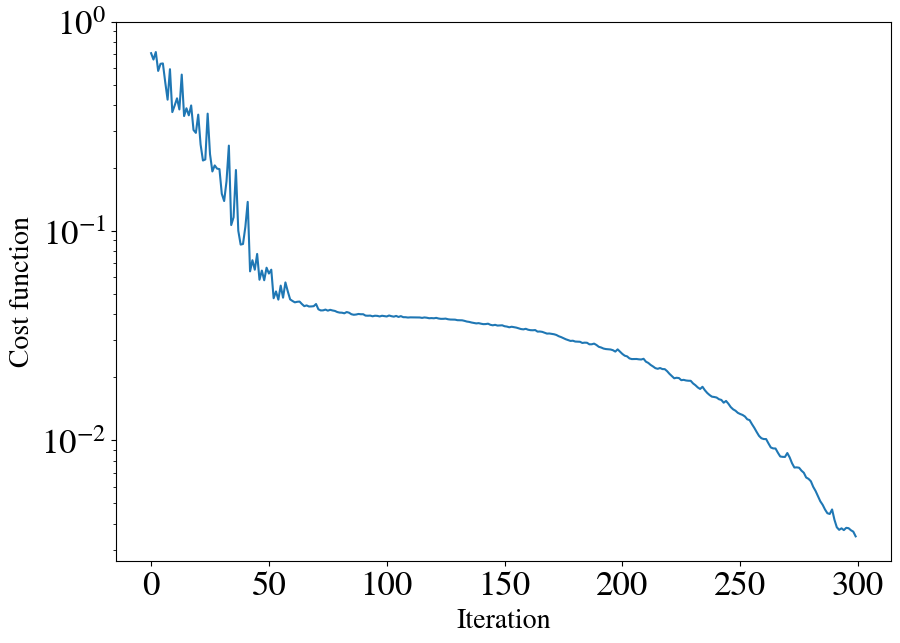




----------- We compare the results with the classic solution of the orignal problem -------
- Classic:
[0.06302085 0.0852018  0.07990046 0.03626709]
- Quantum final solution:
[-0.01016789+0.j  0.00434392+0.j -0.00198357+0.j  0.00031344+0.j
 -0.06443577+0.j -0.08681323+0.j -0.07868822+0.j -0.0421766 +0.j]
- Only the values that we want:
[-0.06443577+0.j -0.08681323+0.j -0.07868822+0.j -0.0421766 +0.j]


In [44]:
#We prepare the system with the previous functions and with the parameters
layers=1
matrixa,vectorb = rlcsystem(dt, R, L, C, w, Vm, 1, [x0,xf])
max_iter = 300

#We run the solution
params, rlc_sol, cfvals = vqls(vectorb, matrixa, layers, "ideal", 0, "local", max_iter)

Now we want the solution vector with the adding the boundary conditions ($I_0$, $I_f$)

In [45]:
#The vector of the times that I need

tvec = np.linspace(0,(dim+1)*dt,(dim+2))

ivec = np.real(rlc_sol)*(-1)
ivec = np.insert(ivec,0,x0)
ivec = np.append(ivec,xf)

quantumsol=[tvec,ivec]
print('Quantum solution:',quantumsol)

Quantum solution: [array([0. , 0.1, 0.2, 0.3, 0.4, 0.5]), array([ 0.        ,  0.06443577,  0.08681323,  0.07868822,  0.0421766 ,
       -0.01027395])]


##Solving it classically

We solve classically the same discretized RLC cirucit, with the same matrix $A$ and vector $\vec{b}$.

### Solving the LSP classically


In [46]:
print('Classic solution to the LSP')
classicsol=np.linalg.solve(matrixa,vectorb)

#We add the boundary conditions x0 and xf
tvecc = np.linspace(0,(dim+1)*dt,(dim+2))
ivecc = np.insert(classicsol,0,x0)
ivecc = np.append(ivecc,xf)

classicsol=[tvecc,ivecc]



Classic solution to the LSP


## Final figure: comparing the results

Ploting the VQLS results for the RLC equation compairing them with the classic solution of the same linear sistem of equations and the analytical solution.

In [47]:
#Plot parameters
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update( {'xtick.labelsize': 25, 'ytick.labelsize': 25, 'font.size': 20} )
import seaborn as sns

# Set the Seaborn color palette
sns.set_palette("colorblind")
color1 = sns.color_palette("colorblind")[0]
color2 = sns.color_palette("colorblind")[1]
color3 = sns.color_palette("colorblind")[2]
color4 = sns.color_palette("colorblind")[3]
color5 = sns.color_palette("colorblind")[4]

plt.rcParams["figure.figsize"] = (10,7)

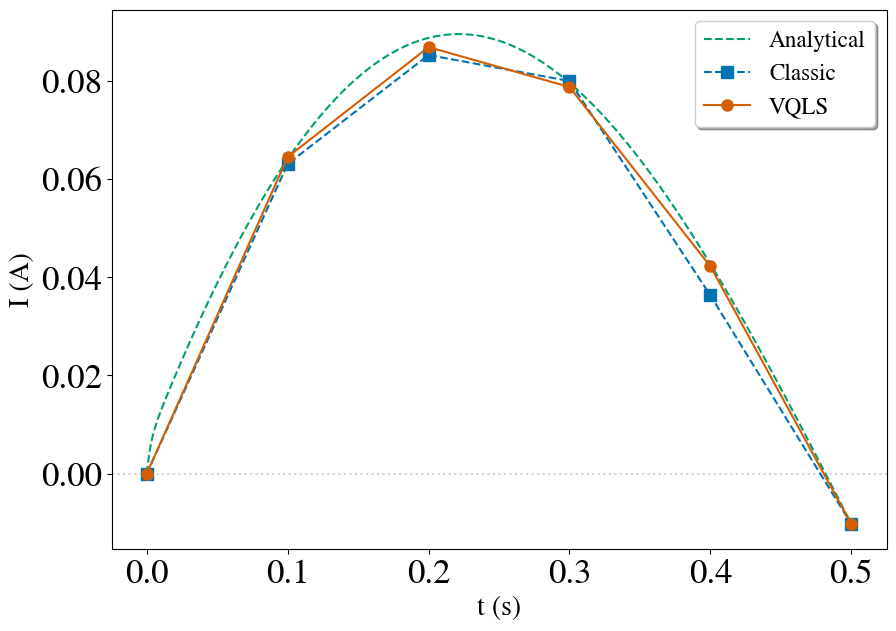

In [49]:
#Final plot

fig, ax = plt.subplots()

ax.axhline(y=0.0, color='lightgray', linestyle=':')
ax.plot(exactsol[0], exactsol[1], label='Analytical', linestyle = '--', linewidth=1.5, color =  color3)
ax.plot(classicsol[0],classicsol[1], label = 'Classic', linestyle = '--', linewidth=1.5, color =  color1, marker = "s", markersize =8)
ax.plot(quantumsol[0], quantumsol[1], label= 'VQLS', linestyle = '-', linewidth=1.5, color =  color4, marker = "o", markersize =8)



#Plots conditions
ax.set(xlabel='t (s)', ylabel='I (A)')
ax.legend(loc='upper right', shadow=True, fontsize='small')

plt.show()




